In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Easy

In [2]:
init_df = pd.read_csv('../data/singapore_airlines_reviews.csv')
init_df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0


In [3]:
def preprocess_text(text: str):
    return re.sub(r'[^\w^\s]+', '', text).lower().split()


def easy_preprocess(text):
    return ' '.join(preprocess_text(str(text)))

In [4]:
set(init_df['published_platform']), set(init_df['type'])

({'Desktop', 'Mobile'}, {'review'})

Выбросим все ненужные колонки и оставим только `text` и `rating`. Создадим новый DataFrame, в котором преобразуем текстовые данные и уберем лишние колонки.

In [5]:
easy_df = init_df.drop(columns=['published_platform', 'type', 'published_date', 'title', 'helpful_votes'])
easy_df['text'] = easy_df['text'].apply(easy_preprocess)
easy_df

,rating,text
0,3,we used this airline to go from singapore to l...
1,5,the service on singapore airlines suites class...
2,1,booked paid and received email confirmation fo...
3,5,best airline in the world seats food service a...
4,2,premium economy seating on singapore airlines ...
...,...,...
9995,5,first part done with singapore airlines accept...
9996,5,and again a great flight with singapore air gr...
9997,5,we flew business class from frankfurt via sing...
9998,4,as always the a380 aircraft was spotlessly pre...


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [7]:
bow = CountVectorizer()
train, test = train_test_split(easy_df, random_state=42)
x_train = bow.fit_transform(train['text'])
x_test = bow.transform(test['text'])
y_train = train['rating']
y_test = test['rating']

<Axes: >

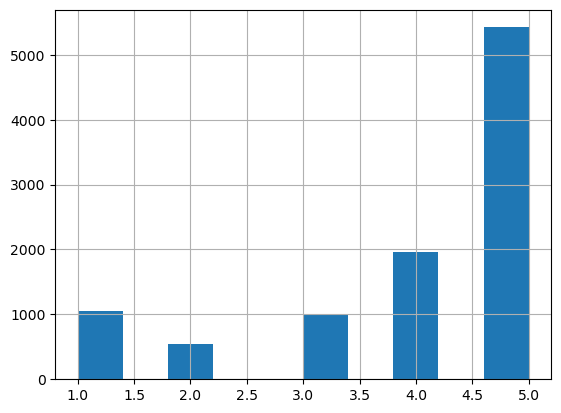

In [8]:
easy_df['rating'].hist()

Сильный дизбаланс классов, будем использовать f1_score с weighted average

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [10]:
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
f1_score(y_pred, y_test, average='weighted')

0.6469979690938111

# Normal

Удалим все стоп-слова и применим стемминг

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

nltk.download('stopwords')
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sergf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def remove_stopwords(text: str):
    stopWords = set(stopwords.words('english'))
    return ' '.join([w for w in text.split() if w not in stopWords])


def medium_preprocess(text: str) -> list:
    return ' '.join([stemmer.stem(word) for word in text.split()])

In [13]:
medium_df = easy_df.copy()
medium_df['text'] = medium_df['text'].apply(remove_stopwords)
medium_df['text'] = medium_df['text'].apply(medium_preprocess)
medium_df

,rating,text
0,3,use airlin go singapor london heathrow issu ti...
1,5,servic singapor airlin suit class noth excel c...
2,1,book paid receiv email confirm extra legroom s...
3,5,best airlin world seat food servic brilliant c...
4,2,premium economi seat singapor airlin narrow se...
...,...,...
9995,5,first part done singapor airlin accept comfort...
9996,5,great flight singapor air great uniqu servic o...
9997,5,flew busi class frankfurt via singapor brisban...
9998,4,alway a380 aircraft spotlessli present board c...


Попробуем обучить ту же самую модель на этих данных

In [14]:
train, test = train_test_split(medium_df, random_state=42)
x_train = bow.fit_transform(train['text'])
x_test = bow.transform(test['text'])
y_train = train['rating']
y_test = test['rating']

In [15]:
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
f1_score(y_pred, y_test, average='weighted')

0.6383793702545792

Что-то не очень хорошо... Попробуем сделать из этого бинарную классификацию на негативные (0-3) и позитивные (4-5) отзывы

In [16]:
import bisect
medium_df['bin_rating'] = medium_df['rating'].apply(lambda x: bisect.bisect_left([3], x))
medium_df

,rating,text,bin_rating
0,3,use airlin go singapor london heathrow issu ti...,0
1,5,servic singapor airlin suit class noth excel c...,1
2,1,book paid receiv email confirm extra legroom s...,0
3,5,best airlin world seat food servic brilliant c...,1
4,2,premium economi seat singapor airlin narrow se...,0
...,...,...,...
9995,5,first part done singapor airlin accept comfort...,1
9996,5,great flight singapor air great uniqu servic o...,1
9997,5,flew busi class frankfurt via singapor brisban...,1
9998,4,alway a380 aircraft spotlessli present board c...,1


In [17]:
train, test = train_test_split(medium_df, random_state=42)
x_train = bow.fit_transform(train['text'])
x_test = bow.transform(test['text'])
y_train = train['bin_rating']
y_test = test['bin_rating']

In [18]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)
f1_score(y_pred, y_test)

0.9215528781793841

Значительно лучше!

Обучим решающее дерево и случайный лес

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
f1_score(y_test, y_pred)

0.8780356179168916

In [21]:
model.get_depth()

195

Глубина очень большая, надо посмотреть, какая оптимальная

In [22]:
from tqdm import tqdm

In [23]:
tree_depth = list(range(5, 201, 5))
res = {}
for depth in tqdm(tree_depth):
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(x_train, y_train)
    res[depth] = f1_score(y_test, model.predict(x_test))

100%|██████████| 40/40 [01:20<00:00,  2.01s/it]


In [24]:
import operator

print(max(res.items(), key=operator.itemgetter(1)))

(20, 0.8950131233595802)


Получилось чуть лучше. Попробуем случайный лес

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
f1_score(y_test, model.predict(x_test))

0.9048582995951417

In [27]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Еще лучше, чем одно дерево! Поподбираем параметры

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
forest_params = {
    'n_estimators': list(range(80, 131, 5)),
    'max_depth': list(range(15, 181, 5)),
}

In [30]:
search = GridSearchCV(RandomForestClassifier(), forest_params, verbose=True)
search.fit(x_train, y_train)
best_forest = search.best_estimator_

Fitting 5 folds for each of 374 candidates, totalling 1870 fits


In [31]:
best_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 180,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 80,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [32]:
f1_score(y_test, best_forest.predict(x_test))

0.9049796747967479

Попробуем предсказать собственный отзыв

In [33]:
def full_preprocess(text: str):
    return medium_preprocess(remove_stopwords(easy_preprocess(text)))


def make_prediction(input: list):
    df = pd.DataFrame()
    df['Review'] = input
    df['Prediction'] = log_reg.predict(bow.transform([full_preprocess(r) for r in input]))
    df['Prediction'] = df['Prediction'].map({0: "Negative", 1: "Positive"})
    return df

In [34]:
reviews = ["A very bad airline. Service quality is just ridiculous, the staff is rude and the wait times are out of this world. Do not recommend.",
           "Have been flying to Berlin with Singapore Airlines last week and was pretty happy with the expirience. Food was not that great but that is often the case wtih every airline. Will definetly fly again with them!"]

In [35]:
make_prediction(reviews)

,Review,Prediction
0,A very bad airline. Service quality is just re...,Negative
1,Have been flying to Berlin with Singapore Airl...,Positive


Ответы правильные!

# Hard

In [36]:
hard_reviews = ["Everything was just... : the flight was delayed by JUST 5 hours, the luggage was JUST lost and the flight was JUST as satisfying as the trip to hell.",
                "Good service and great experience is not a thing at Singapore Airlines now, right? Correct me if I wrong but this used to be an excellent company to travel with and I can't understand what has happened.",
                "The only good thing was the fact that we didn't die during the flight. Everything else was far from perfect.",
                "There was no part of this travel that I really enjoyed.",
                "If you do not have any repect to yourself and want to forget what comfort is for the next 4-8 hours Singapore is the right airline to go to.",
                "Too bad I have found this airline only now. After so many ruined holidays with other airlines it was finally a relief to meet some competency.",
                "The disappointment was that I had to leave the plane. Some problems were rising but dealt with rather fast. Even the terrible weather was not a hindrance for the smooth flight.",
                "I was rather awfully skeptical about this journey in the beginning and was afraid and even panicked since this was my first flight but everything was okay at the end of the day (though the food was pretty bad).",
                "Bad trip saved! As we were on the verge of getting late because of an awful traffic Singapore made us an express-boarding and we made it!",
                "Even though I am slow and like to take my time, we managed to get everywhere on time! Not to be rude but this was a fricking fab experience"
                ]

In [37]:
make_prediction(hard_reviews)

,Review,Prediction
0,Everything was just... : the flight was delaye...,Positive
1,Good service and great experience is not a thi...,Positive
2,The only good thing was the fact that we didn'...,Positive
3,There was no part of this travel that I really...,Positive
4,If you do not have any repect to yourself and ...,Positive
5,Too bad I have found this airline only now. Af...,Negative
6,The disappointment was that I had to leave the...,Negative
7,I was rather awfully skeptical about this jour...,Negative
8,Bad trip saved! As we were on the verge of get...,Negative
9,Even though I am slow and like to take my time...,Negative


Обманывать модель получилось следующим образом: чтобы написать ложно-положительные отзывы, достаточно использовать сарказм. Сарказм в основном использует позитивные слова в негативных значениях, поэтому модель не может отличить их от true positive отзывов. Помимо сарказма можно ставить отрицания далеко от позитивных слов в предложении, чтобы модель не поняла, что они относятся друг к другу (как, например, в отзыве 3). Составлять ложно-негативные отзывы оказалось сложнее: сарказм здесь не используешь, поскольку он имеет преимущественно негативное значение. Выяснилось, что модель срабатывает больше всего на слова 'bad', 'slow', 'rude', 'delay'. Если использовать их в отзыве, но описывать с их помощью что-то другое (пробки, или просто в выражении 'too bad I', которое несёт позитивный смысл), а также не использовать популярных позитивных маркеров ('enjoyable', 'pleasant', 'good' и т.д., их довольно много), то модель посчитает отзыв отрицательным. Вместо общеиспользуемых позитивных слов можно добавлять, например, редкие синонимы или сленговые сокращения/выражения.  